# Lora Data Processing

In [1]:
import pathlib
import numpy as np
import more_itertools as mit
import re
from scipy import signal as spsig
from scipy.signal import argrelextrema
from scipy.signal import argrelmin

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

from tqdm.notebook import trange, tqdm

from six.moves import cPickle


Fs = int(1e6)

## Functions

In [2]:
## utility functions

def glob_files(path, pattern=r'**/*.dat'):
    yield from (file for file in data_dir.glob('**/*.dat'))
    

def _extract_digit(pattern, text):
    """ helper for extract_bw_and_sf """
    try:
        match = int(re.search(pattern, text)[1])
    except:
        print('ERROR! unable to extract bw or sf')
        return 
    else:
        return match 
    
    
def extract_bw_and_sf(filename, BW_val):
    """ extracts params from input filename """
    _bw_pattern, _sf_pattern, _l_pattern = r'BW(\d{1,})', r'SF(\d{1,})', r'L(\d)'
    
    bw_match = _extract_digit(_bw_pattern, filename)
    if bw_match is not None:
        bw_match = BW_val[bw_match - 1]
    
    sf_match = _extract_digit(_sf_pattern, filename)
    
    l_match = _extract_digit(_l_pattern, filename)
    
    return bw_match, sf_match, l_match

def check_and_load_file(filepath):
    filepath = pathlib.Path(filepath)
    
    if not isinstance(filepath, pathlib.Path) or not filepath.exists():
        print(f'ERROR! unable to find input file at:\n{filepath}')
        return
        
    return filepath

## get encoding parameters

def get_and_set_encoding_params(filepath):
    BW_val = np.array([10.4e3, 15.6e3, 0, 0, 0, 0, 125e3, 250e3, 500e3])
    BW, SF, L = extract_bw_and_sf(filepath.name, BW_val) 
    Fs = int(1e6)
    sampPerSym = np.round(((2**SF)/BW)*Fs)
    pcktLen = 30.25*sampPerSym

    print(f'BW: {BW} | SF: {SF} | Fs: {Fs} | Samples Per Symbol: {sampPerSym} | Packet Length: {pcktLen}')
    return BW, SF, sampPerSym, L, pcktLen
## load data

def load_data(filepath):
    try:
        signal = np.fromfile(filepath, dtype=np.complex64)
    except Exception as exc:
        print(f'unable to load file:\n{exc}')
        return 
    else:
        print(f'loaded signal with {signal.size} samples')
        return signal

## normalize signal

def normalize_signal(signal, th=0.001):
    real_s = np.abs(np.real(signal)) 
    
    norm_s = np.array([
        np.ceil(val) if val >= th else 0
        for val in real_s
    ])
    return real_s, norm_s

### locate zero indices

def _locate_zero_indices(norm_signal):
    indices = np.where(norm_signal == 0.0)[0]
    
    return indices

### find consecutive groups 

def _find_consecutive_groups(zero_indexes):
    groups = [
        list(j) for j in 
        mit.consecutive_groups(sorted(list(set(zero_indexes))))
    ]
    
    lengths = np.array(
        [len(item) for item in groups]
    )
    
    print(f'found {len(groups)} groups')
    return groups, lengths

### locate endpoints

def _locate_endpoints(groups, threshold=15_000):
    all_endpoints = [
        endpoints for group in groups
            if len(group) > threshold
        for endpoints in (group[0], group[-1])
    ]
    
    endpoint_pairs = [
        (start, stop) 
        for start, stop in zip(all_endpoints[1::2], all_endpoints[2::2])
    ]
    
    print(f'Extracted {len(endpoint_pairs)} packets from signal')
    return endpoint_pairs

## extract endpoints

def plot_groups(indexes, lengths, filename):
    fig, axs = plt.subplots(2)
    fig.suptitle(f'{filename}')
    axs[0].plot(indexes)
    axs[1].plot(lengths)
    
    #plt.savefig(f'plots/{filename}.png')
    return fig

def extract_endpoints(normalized_signal, filename, threshold=15_000):
    zero_indexes = _locate_zero_indices(normalized_signal)
    consec_groups, groups_lengths = _find_consecutive_groups(zero_indexes)

    # validation plot 
    plot_groups(zero_indexes, groups_lengths, filename)
    
    endpoint_pairs = _locate_endpoints(consec_groups, threshold)
    return endpoint_pairs


## smoothing method 


def _moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n



def preprocess(signal, scale_factor, window_length=17_000):
    real_s = np.abs(np.real(signal))
    
    down_s = _moving_average(
        spsig.decimate(real_s, scale_factor, ftype='iir'), 
        n=window_length // scale_factor
    )
    print(f'decimated by a factor of {scale_factor} | size: {down_s.size}')
    
    return real_s, down_s
    
    
    
def find_minima(signal, window=8_000):
    minima = spsig.argrelmin(signal, order=int(window))[0]
    
    return minima


def _generate_minima_plot(minima, size):
    minima_plot = np.zeros(size)
    
    for val in minima:
        minima_plot[val] = 1 
        
    return minima_plot


def _average_packet_length():
    sampPerSym = np.round(((2**SF)/BW)*Fs)
    pcktLen = 30.25*sampPerSym
    return pcktLen


    
def _plot_comparison(real, down, minima):
    fig, axs = plt.subplots(3)
    fig.set_figwidth(10), fig.set_figheight(12)
    axs[0].plot(real[100_000:])
    axs[1].plot(down[1000:])
    axs[2].plot(_generate_minima_plot(minima, down.size)[1000:])

    
def _generate_endpoints(minima, scale, sampPerSym):
    packet_length = 30.25*sampPerSym
    return [
        (int(val*scale), int(val*scale+packet_length))
        for val in minima
    ]

def extract_indices(signal, scale_factor=101, window_length=17_000):
    real_s, down_s = preprocess(signal, scale_factor, window_length)
    
    packet_len = _average_packet_length()
    minima = find_minima(down_s, window=packet_len//scale_factor)
    
    _plot_comparison(real_s, down_s, minima)
    return minima 


def extract_endpoints_od(signal, scale_factor=101, window_length=17_000):
    minima = extract_indices(signal, scale_factor, window_length)
    
    endpoints = _generate_endpoints(minima, scale_factor, sampPerSym)
    return endpoints


## packet slicing

def _slice_and_pad(signal, endpoints, length):
    start, stop = endpoints
    sliced = signal[start:stop] 
    
    if len(sliced) < length:
        sliced = np.concatenate((
            sliced, np.zeros(length - len(sliced))
        ))
        
    return sliced


def slice_all_packets(signal, endpoints):
    max_length = max(stop - start for start, stop in endpoints)
    print(f'got max packet length: {max_length}')
    
    packets = np.vstack(
        tuple(
            _slice_and_pad(signal, pair, max_length)
            for pair in endpoints
        )
    )
    
    print(f'Extracted {len(packets)} packets from signal')
    return packets
    

## Define Directory

In [7]:
data_dir = pathlib.Path('data/LoRa_Recording_Outdoor')
all_data_files = list(glob_files(data_dir))

file = all_data_files[2]
print(file)
signal = np.fromfile(file, dtype=np.complex64)

data/LoRa_Recording_Outdoor/lora_BW1_SF8_914_75MHz_1Msps_L24.dat


## process outdoor

BW: 10400.0 | SF: 8 | Fs: 1000000 | Samples Per Symbol: 24615.0 | Packet Length: 744603.75
decimated by a factor of 101 | size: 519729
got max packet length: 744603
Extracted 58 packets from signal


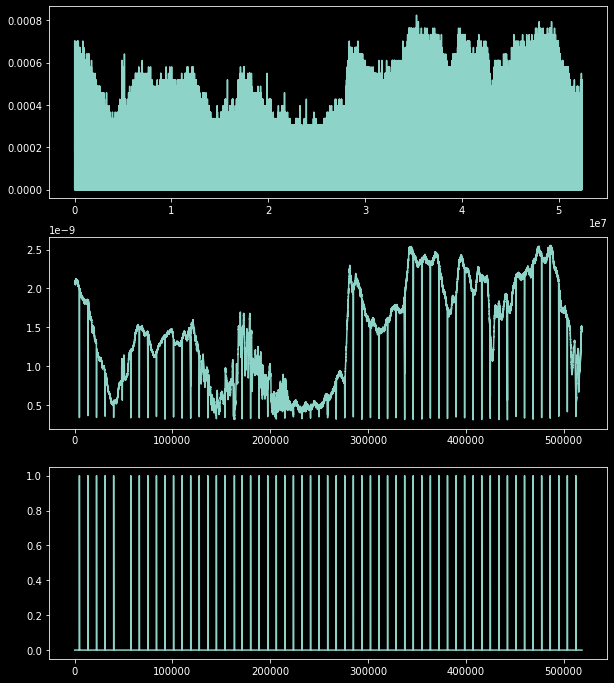

In [9]:
BW, SF, sampPerSym, L, pcktLen = get_and_set_encoding_params(file) 

endpoints = extract_endpoints_od(signal)

packets = slice_all_packets(signal, endpoints)

## convolution schtuff

In [ ]:
from six.moves import cPickle

with data_dir.joinpath('lora_symbols_BW250000_SF11_L0.p').open('rb') as file:
# with open('Processed_Data/Indoors/Location0/lora_symbols_BW250000_SF11_L0.p', mode='rb') as file:        
    basline = cPickle.load(file)

baseline = basline[0,:]
plt.plot(np.real(baseline))

In [ ]:
N = int(np.floor(len(signal)/len(basline)))

samps = len(baseline)
window = 100
c_out = []
index = []
k = 0
for i in range(N):
    if k < len(signal):
        sig = signal[k:k+samps]
        sig_c = np.conj(sig[::-1])
        conv_val = np.abs(np.convolve(baseline,sig_c))/np.linalg.norm(sig)/np.linalg.norm(sig)

        c_out.append(np.max(conv_val))
        index.append(k)
        k = k + samps - window
    else:
        break

In [ ]:
while k < len(signal):
    pass 

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(c_out)


In [ ]:
start_index = []
N = len(c_out)
for i in range(N):
    if c_out[i] >= 10:
        start_index[i]=k[i]
        
        
#fig = plt.figure(figsize=(20,10))
#plt.plot(c_out[1:100])


## Param dict 

In [ ]:
N = 0.0005
N1 = 0.0003 

param_dict = {
    # location 0 
    'lora_BW1_SF10_915MHz_1Msps_L0.dat': N,
    'lora_BW1_SF11_915MHz_1Msps_L0.dat': N,
    'lora_BW1_SF12_915MHz_1Msps_L0.dat': N,
    'lora_BW2_SF10_915MHz_1Msps_L0.dat': N,
    'lora_BW2_SF11_915MHz_1Msps_L0.dat': N,
    'lora_BW2_SF12_915MHz_1Msps_L0.dat': N,

    
    # location 1 
    'lora_BW1_SF10_915MHz_1Msps_L1.dat': N,
    'lora_BW1_SF11_915MHz_1Msps_L1.dat': N,
    'lora_BW1_SF12_915MHz_1Msps_L1.dat': 0.0003,
    'lora_BW2_SF10_915MHz_1Msps_L1.dat': N,
    'lora_BW2_SF11_915MHz_1Msps_L1.dat': N,
    'lora_BW2_SF12_915MHz_1Msps_L1.dat': N,

    
    # location 2 
    'lora_BW1_SF10_915MHz_1Msps_L2.dat': N,
    'lora_BW1_SF11_915MHz_1Msps_L2.dat': N,
    'lora_BW1_SF12_915MHz_1Msps_L2.dat': N,
    'lora_BW2_SF10_915MHz_1Msps_L2.dat': 0.0003,
    'lora_BW2_SF11_915MHz_1Msps_L2.dat': N,
    'lora_BW2_SF12_915MHz_1Msps_L2.dat': N,
    'lora_BW7_SF12_915MHz_1Msps_L2.dat': N,
    'lora_BW9_SF12_915MHz_1Msps_L2.dat': 0.00035,
    
    # location 3 
    'lora_BW1_SF10_915MHz_1Msps_L3.dat': N,
    'lora_BW1_SF11_915MHz_1Msps_L3.dat': N,
    'lora_BW1_SF12_915MHz_1Msps_L3.dat': N,
    'lora_BW2_SF10_915MHz_1Msps_L3.dat': N,
    'lora_BW2_SF11_915MHz_1Msps_L3.dat': N,
    'lora_BW2_SF12_915MHz_1Msps_L3.dat': N,
    'lora_BW7_SF11_915MHz_1Msps_L3.dat': 0.00035,
    
    # location 4 
    'lora_BW1_SF10_915MHz_1Msps_L4.dat': N,
    'lora_BW1_SF11_915MHz_1Msps_L4.dat': N,
    'lora_BW1_SF12_915MHz_1Msps_L4.dat': N,
    'lora_BW2_SF10_915MHz_1Msps_L4.dat': N,
    'lora_BW2_SF11_915MHz_1Msps_L4.dat': N,
    'lora_BW2_SF12_915MHz_1Msps_L4.dat': N,
    
    # location 5 
    'lora_BW1_SF10_915MHz_1Msps_L5.dat': N,
    'lora_BW1_SF11_915MHz_1Msps_L5.dat': N,
    'lora_BW1_SF12_915MHz_1Msps_L5.dat': N,
    'lora_BW2_SF10_915MHz_1Msps_L5.dat': N,
    'lora_BW2_SF11_915MHz_1Msps_L5.dat': N,
    'lora_BW2_SF12_915MHz_1Msps_L5.dat': N
}

## Extract Packets

In [ ]:
def extract_packets(filepath, norm_thresh=0.001, packet_thresh=15_000):
    filepath = check_and_load_file(filepath)    
    print(f'norm threshold: {norm_thresh}')
    
    get_and_set_encoding_params(filepath) 
    signal = load_data(filepath)
    
    #N = 3_000_000 
    N = len(signal)
    
    real_s, norm_s = normalize_signal(signal[0:N], norm_thresh)
    print("Normalization Complete")
  
    endpoint_pairs = extract_endpoints(norm_s, filepath.name, packet_thresh)
    print("Endpoint Pairs Extracted. Total: " + str(np.shape(endpoint_pairs)))

    all_packets = slice_all_packets(signal[0:N], endpoint_pairs)
    print("Total Packets: " + str(np.shape(all_packets)))
    return all_packets

In [ ]:
len(all_data_files)

In [ ]:
all_packets = extract_packets(file, norm_thresh=param_dict.get(file.name, 0.001) , packet_thresh=17_200)

In [ ]:
num2check = 9
fig = plt.figure(figsize=(10,20))
for i in range(num2check):
    plt.subplot(9,3,i+1)
    #plt.plot(np.real(all_packets[i,:]))
    fft_1 = np.abs(np.fft.fftshift(np.abs(np.fft.fft(all_packets[0,:]))))
    plt.plot(fft_1)

### Extract Symbols

In [ ]:
BW, SF, sampPerSym, location = get_and_set_encoding_params(file)
BW, SF, sampPerSym = int(BW), int(SF), int(sampPerSym)
numPackets = all_packets.shape[0]
numSymbols = 8

print("Total Packet:" + str(numPackets))
print("Symbols to Extract: " + str(numSymbols))


In [ ]:
symbols = np.empty([numPackets*numSymbols,sampPerSym], dtype='complex')
N = symbols.shape[0]
k,l = 0, 0
for i in range(numPackets):
    for j in range(numSymbols):
        symbols[l,:] = all_packets[i,k:k+sampPerSym]
        k = k + sampPerSym
        l = l+1
    k = 0

In [ ]:
symbols.shape

In [ ]:
num2check = 9
fig = plt.figure(figsize=(10,20))
for i in range(num2check):
    plt.subplot(9,3,i+1)
    plt.plot(np.real(symbols[i,:]))



In [ ]:
fig = plt.figure(figsize=(10,20))
for i in range(num2check):
    plt.subplot(9,3,i+1)
    fft_s = np.abs(np.fft.fftshift(np.abs(np.fft.fft(symbols[i,:]))))
    plt.plot(fft_s)

### Save data to file

In [ ]:
dir_ = 'Processed_Data/Location' + str(location) + "/"
filename = "lora_symbols_BW" + str(BW) + "_SF" + str(SF) + "_L" + str(location) + ".p"
print(dir_+filename)

In [ ]:
cPickle.dump(symbols, open(dir_+filename,'wb'))

### Check Saved Data

In [ ]:
with open(dir_+filename, mode='rb') as file:        
    test1 = cPickle.load(file)

#with open('lora_symbols_BW250000_SF12_L2.p', mode='rb') as file:        
#    test2 = cPickle.load(file)



In [ ]:
plt.subplot(2,1,1)
fft_1 = np.abs(np.fft.fftshift(np.abs(np.fft.fft(test1[0,:]))))
plt.plot(fft_1)

plt.subplot(2,1,2)
fft_1 = np.abs(np.fft.fftshift(np.abs(np.fft.fft(test2[1,:]))))
plt.plot(fft_2)